<a href="https://colab.research.google.com/github/Brayancrc/intencao_de_compras-/blob/main/intencaocompras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Análise de intenção de compras online com Python**

Começarei com esta tarefa importando as bibliotecas necessárias e os dados:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
# read the dataset
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/DataScienceModels/online_shoppers_intention.csv")

Mounted at /content/drive


Agora vamos dar uma olhada nos valores ausentes e preenchê-los usando o método fillna no Python pandas:

In [2]:
missing = data.isnull().sum()
print(missing)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [3]:
data.fillna(0, inplace = True)

Agora dê uma olhada nas taxas de rejeição de clientes relacionadas a produtos:

In [4]:
x = data.iloc[:, [5, 6]].values
x.shape

(12330, 2)

Agora vamos aplicar o método K-elbow para determinar o número de grupos de agrupamento:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.p

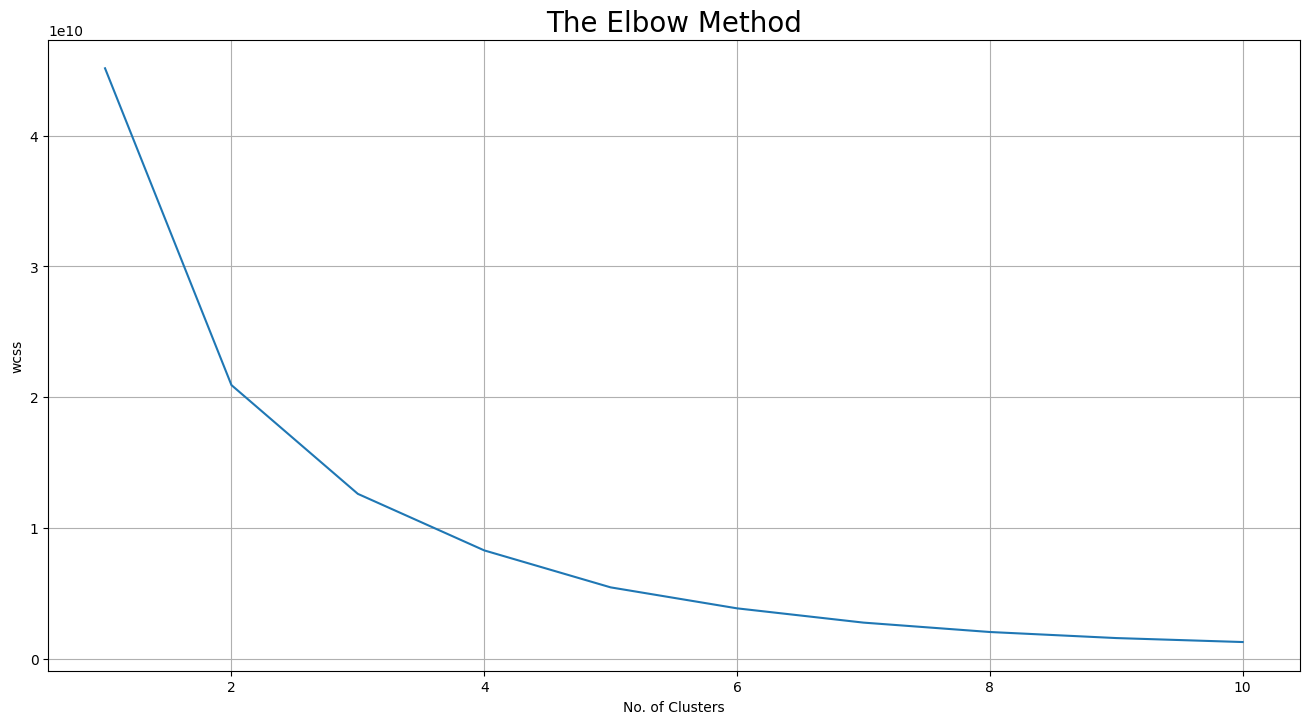

In [5]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i,
              init = 'k-means++',
              max_iter = 300,
              n_init = 10,
              random_state = 0,
              algorithm = 'full',
              tol = 0.001)
    km.fit(x)
    labels = km.labels_
    wcss.append(km.inertia_)

plt.rcParams['figure.figsize'] = (13, 7)
plt.plot(range(1, 11), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

**K Means Clustering**

De acordo com o gráfico acima, a curvatura máxima está no segundo índice, ou seja, o número de grupos de clustering ótimos para a duração do produto e as taxas de rejeição é 2. Uma vez determinado o número de clusterings, aplicamos o método K Means e plotamos os clusters:

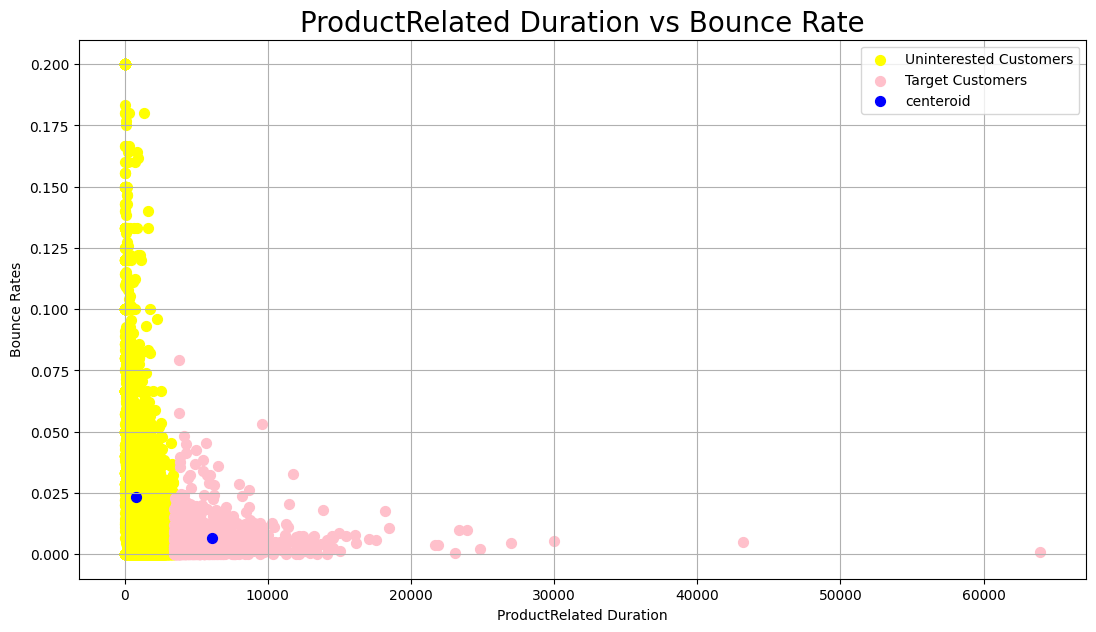

In [6]:
km = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# get predicted cluster index for each sample: 0, 1, 2
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 50, c = 'yellow', label = 'Uninterested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 50, c = 'pink', label = 'Target Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('ProductRelated Duration vs Bounce Rate', fontsize = 20)
plt.grid()
plt.xlabel('ProductRelated Duration')
plt.ylabel('Bounce Rates')
plt.legend()
plt.show()

Olhando para este gráfico de agrupamento K Means, podemos dizer com certeza que os clientes que passaram mais tempo em um site relacionado a produtos têm muito menos probabilidade de sair do site após visualizar uma única página.

Como o K-Means não é um método de aprendizado supervisionado, estamos adotando outras maneiras de avaliar seu resultado de agrupamento. A coluna mais à esquerda da matriz de confusão representa o rótulo real (receita Verdadeira ou Falsa), e a linha superior representa os grupos de agrupamento esperados (clientes desinteressados ​​ou clientes-alvo):

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_true = le.fit_transform(data['Revenue'])

# get predicted clustering result label
labels_pred = y_means

# print adjusted rand index, which measures the similarity of the two assignments
from sklearn import metrics
score = metrics.adjusted_rand_score(labels_true, labels_pred)
print("Adjusted rand index: ")
print(score)

# print confusion matrix
#cm = metrics.plot_confusion_matrix(None, labels_true, labels_pred)
#print(cm)
import scikitplot as skplt
plt_1 = skplt.metrics.plot_confusion_matrix(labels_true, labels_pred, normalize=False)
plt_2 = skplt.metrics.plot_confusion_matrix(labels_true, labels_pred, normalize=True)

Adjusted rand index: 
0.08359442469281096


ImportError: cannot import name 'interp' from 'scipy' (/usr/local/lib/python3.10/dist-packages/scipy/__init__.py)

**Observações dos gráficos acima:**

Da matriz de confusão, podemos ver que de 10.422 rendas fracassadas, 9.769 são agrupadas em clientes desinteressados ​​ou 94%. No entanto, de 937 rendas bem-sucedidas, apenas 284 são agrupadas como clientes-alvo ou 15%. Além disso, a pontuação do índice ajustado não é muito alta.

Então está claro que nós agrupamos mal muitas sessões de receita bem-sucedidas como clientes desinteressados, o que significa que quando a alta taxa de rejeição combinada com uma curta duração de página relacionada ao produto, ainda há muitos clientes alvos.